# Jonathan Souty - Inlämning 1
## 1. Data Exploration

Importing the libraries we will be using

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

line_break = '\n' + ('-' * 50) + '\n'

Defining the local file path and loading it into a pandas dataframe

In [ ]:
file_path = 'C:/Users/jonat/Documents/python/pyabon/ml_inlämning_1/AmazonDataSales.csv'
df = pd.read_csv(file_path)

First we get an overview of our data, the pandas function to display all columns when running df.head() is nice here because we are just above the limit where it cuts out a few of our columns

In [ ]:
# setting option to display all the columns
pd.set_option('display.max_columns', None)
# using df.head() instead of print(df.head()) gives a better view of the data
df.head()

Here we learn more about each column in the dataset to get a better understanding of our cleaning and transformation needs

In [ ]:
# describe the dataframe
print(df.describe(include='all'))

# total rows = 128 975
# there are a few duplicates of Order ID, seems like its the same order but with different products

Checking for any odd or unwanted datatypes. For example, here we learn that the 'B2B' column is of the boolean datatype, which we would rather have as integers (0, 1)

In [ ]:
# print datatypes
df.dtypes

Checking the columns for missing values to help us make decisions on how to handle the inconsistencies. We either fill the missing data using some form of logic or we drop certain columns and rows

In [ ]:
# check for missing values
print("Count of missing values per column:")
print(df.isnull().sum())

We also check for duplicates, I did notice that we have a few hidden duplicates.

In [ ]:
# check for duplicates in all columns
print("Count of duplicates per column:")
print(df.duplicated().sum())

## 2. Data Cleaning

#### I used my own reasoning and with some help of the provided DataProcessMLSemi.py to figure out the cleaning needs

We have 6872 missing values in the Courier Status column out of the ~128k total

In [ ]:
# check Courier Status column aswell as how many null values there are
print(df['Courier Status'].value_counts(dropna=False))

I decided to replace the NaN values with 'Unknown'

In [ ]:
# replace NaN values with 'Unknown'
df['Courier Status'].fillna('Unknown', inplace=True)
print(df['Courier Status'].value_counts(dropna=False))

Getting a better idea of how to handle the 'currency' column

In [ ]:
# check the currency column
print(df['currency'].value_counts(dropna=False))

print(line_break)

# print the rows where currency is null
print(df[df['currency'].isnull()])

print(line_break)

# check how many rows there are where currency is null but the Amount column isnt null
print('Rows with null currency but not null Amount:')
print(df[(df['currency'].isnull()) & (df['Amount'].notnull())])

Since all of the missing currency inputs also has ship-country = India, I decided to fill the missing currencies with INR

In [ ]:
# we only have INR currency so its safe to assume that the null values are INR
df['currency'].fillna('INR', inplace=True)
print(df['currency'].value_counts(dropna=False))

In the data exploration phase phase I noticed that we have some NaN values in the 'ship-*' columns so here we dive deeper into those columns

In [ ]:
# check the ship-city, ship-state, ship-postal-code, ship-country columns for NaN values
print(df['ship-city'].isnull().sum())
print(df['ship-state'].isnull().sum())
print(df['ship-postal-code'].isnull().sum())
print(df['ship-country'].isnull().sum())

print(line_break)

# check the rows where ship-city is not null
print(df[df['ship-city'].isnull()])

I determined that its safe to fill the NaN values with 'Unknown' because I feel like those values will not have an impact on the analysis

In [ ]:
# filling missing values with 'Unknown' in columns ship-city, ship-state, ship-country
df['ship-city'].fillna('Unknown', inplace=True)
df['ship-state'].fillna('Unknown', inplace=True)
df['ship-country'].fillna('Unknown', inplace=True)

# since ship-postal-code is a float column i will change it to string and change the missing values to 'Unknown', we can leave it as string as we wont be doing any calculations on it
df['ship-postal-code'] = df['ship-postal-code'].astype(str)
df['ship-postal-code'].fillna('Unknown', inplace=True)

 Noticed a high amount of hidden duplicates in the 'ship-city' column, as you can see below we have 8 different variates of 'Ahmedabad'

It seems to be an issue with how the data is being inputted, will not solve this issue right now

In [ ]:
# filter the DataFrame for rows where 'ship-city' contains 'Ahmedabad'
ahmedabad_df = df[df['ship-city'].str.contains('Ahmedabad', na=False)]

# print the value counts of different variations of 'Ahmedabad' in the 'ship-city' column
print(ahmedabad_df['ship-city'].value_counts(dropna=False))

These two columns has alot of mixed lower/uppercase strings. For now we will just convert all the strings in ship-city and ship-state to lowercase

In [ ]:
# convert all the strings in 'ship-city' and 'ships-state' columns to lowercase
df['ship-city'] = df['ship-city'].str.lower()
df['ship-state'] = df['ship-state'].str.lower()

A simple way to visualize which columns have a large amount of missing values

In [ ]:
# check all the columns for missing values in percentage compared to total rows and sort them in descending order
missing_percentage = df.isnull().sum() / len(df) * 100
missing_percentage.sort_values(ascending=False, inplace=True)
print(missing_percentage)

As we saw in the earlier block 'fulfilled-by', 'Unnamed: 22', 'promotion-ids' columns has 34-69% missing values so we will drop those columns

In [ ]:
# dropping the columns with more than 34-69% values missing
df.drop(['fulfilled-by', 'Unnamed: 22', 'promotion-ids'], axis=1, inplace=True)

I cant really justify filling the missing values in the 'Amount' column with anything that will have a positive impact on the model so I decided to drop the ~5% of total rows

In [16]:
# since the Amount column only has about 5% null values i have decided to drop those rows
df.dropna(subset=['Amount'], inplace=True)

# count total rows of amount
print('Total rows remaining:')
print(len(df['Amount']))

Total rows remaining:
121180


Analyzing the 'Qty' and 'Amount' columns for negative values and correcting them if found

In [19]:
# check if the 'Qty' column has any negative values and correct them if true
if (df['Qty'] < 0).any():
    print('Qty has negative values. Corrected them now...')
    df['Qty'] = df['Qty'].clip(lower=0)
else:
    print('Qty has no negative values')

# check if the 'Amount' column has any negative values and correct them if true
if (df['Amount'] < 0).any():
    print('Amount has negative values. Corrected them now...')
    df['Amount'] = df['Amount'].clip(lower=0)
else:
    print('Amount has no negative values')

Qty has no negative values
Amount has no negative values


First I planned to use a normal if islower then convert to upper but apparently that wouldn't work with mixed upper/lower, the lambda function however, is able to do this.

In [21]:
# checks for any lowercase character within each string and converts them to uppercase
lowercase_count = df['Style'].apply(lambda x: any(c.islower() for c in x)).sum()
total_row_count = len(df['Style'])

if lowercase_count > 0:
    print(f'Lowercase characters found in {lowercase_count}/{total_row_count} rows of Style column. Converted them to uppercase.')
    df['Style'] = df['Style'].str.upper()
else:
    print('All characters in Style column are already uppercase.')

Lowercase characters found in 56912/121180 rows of Style column. Converted them to uppercase.


Just to test if the code in the block above works properly

In [20]:
half_count = len(df) // 2

# convert the first half of the 'Style' column to lowercase
df.loc[:half_count, 'Style'] = df.loc[:half_count, 'Style'].str.lower()

# same as previous code block just to get the order right
if lowercase_count > 0:
    print(f'Lowercase characters found in {lowercase_count}/{total_row_count} rows of Style column. Converted them to uppercase.')
    df['Style'] = df['Style'].str.upper()
else:
    print('All characters in Style column are already uppercase.')

All characters in Style column are already uppercase.


Converting the 'Date' column to datetime and changing the format to the "best" one :D

In [ ]:
# convert 'Date' column to datetime and change format to YYYY-MM-DD
df['Date'] = pd.to_datetime(df['Date'], format='%m-%d-%y', errors='coerce')

# print the first 5 rows of the Date column
print(df['Date'].head())

I noticed some mixed lowercase/uppercase in the 'Category' column so I decided to change them all to lowercase

In [ ]:
# change all the 'Category' column values to lowercase
df['Category'] = df['Category'].str.lower()

# check the 'Category' column
print(df['Category'].value_counts(dropna=False))

Just doing some midway data exploration to see if there is anything else that needs to be done in the cleaning phase

In [ ]:
# check the cleaned dataset
print("DataFrame Description:")
print(df.describe(include='all'))

print(line_break)

# check all columns for missing values
print("Count of missing values per column:")
print(df.isnull().sum())

print(line_break)

# print total remaining rows
print('Total rows remaining:')
print(len(df))

## 3. Feature Engineering

#### First we will create new columns using the Date column
 I chose to only extract Weekday (Monday-Sunday) and Is_weekday TRUE/FALSE (0/1)

In [25]:
# adding a column for 'Weekday' using the 'Date' column
df['Weekday'] = df['Date'].dt.day_name()

# adding a column for 'Is_weekday' using the 'Date' column
# the lambda function will check if the day of the week is 5 or 6 (saturday or sunday) and return 1 if true and 0 if false
df['Is_weekday'] = df['Date'].dt.dayofweek.apply(lambda x: 0 if x >= 5 else 1)

In [ ]:
# to check if it works we are printing only weekday and is_weekday columns, one where weekday is monday and the other where weekday is saturday
print(df[['Weekday', 'Is_weekday']][df['Weekday'] == 'Monday'].head())
print(df[['Weekday', 'Is_weekday']][df['Weekday'] == 'Saturday'].head())

 Converting the 'B2B' column from TRUE/FALSE to binary. I learned that I can instantly convert a bool column to int and all the values TRUE/FALSE will be automatically converted to 1/0

In [29]:
# check the values in the 'B2B' column
print(df['B2B'].value_counts(dropna=False))

print(line_break)

# check the datatype of the 'B2B' column
print('Datatype:')
print(df['B2B'].dtypes)

B2B
0    120337
1       843
Name: count, dtype: int64

--------------------------------------------------

Datatype:
int32


In [30]:
# convert the 'B2B' TRUE values to 1 and FALSE values to 0, since the datatype is bool we can just convert it to int
df['B2B'] = df['B2B'].astype(int)
print(df['B2B'].value_counts(dropna=False))

B2B
0    120337
1       843
Name: count, dtype: int64


Getting a better understanding of the 'Amount' column by using the describe function aswell as visualizing it to get a better idea

Description of 'Amount' column:
count    121180.000000
mean        648.561465
std         281.211687
min           0.000000
25%         449.000000
50%         605.000000
75%         788.000000
max        5584.000000
Name: Amount, dtype: float64

--------------------------------------------------

Distribution of 'Amount' column:


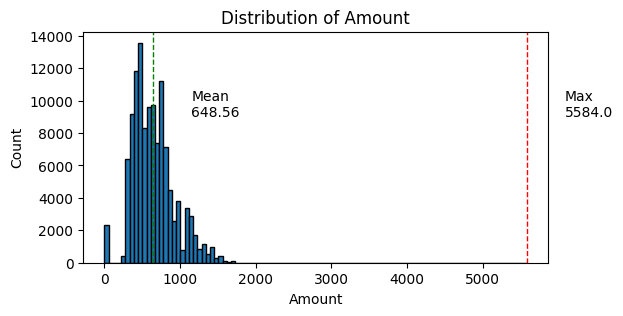

In [31]:
# lets find out more about the 'Amount' column
print("Description of 'Amount' column:")
print(df['Amount'].describe())

print(line_break)

# lets visualize the distribution of the 'Amount' column
print("Distribution of 'Amount' column:")
plt.figure(figsize=(6, 3))
plt.hist(df['Amount'], bins=100, edgecolor='black')
plt.title('Distribution of Amount')
plt.xlabel('Amount')
plt.ylabel('Count')
plt.axvline(df['Amount'].max(), color='red', linestyle='dashed', linewidth=1)
plt.text(df['Amount'].max() + 500, 10000, 'Max', rotation=360)
plt.text(df['Amount'].max() + 500, 9000, df['Amount'].max())
plt.axvline(df['Amount'].mean(), color='green', linestyle='dashed', linewidth=1)
plt.text(df['Amount'].mean() + 500, 10000, 'Mean', rotation=360)
plt.text(df['Amount'].mean() + 500, 9000, round(df['Amount'].mean(), 2))
plt.show()

In the earlier block I learned that we have some extreme outliers, after consulting my colleague mr GPT I decided to do a log transformation on the 'Amount' column

In [32]:
# adding 1 to the 'Amount_Log' column to avoid dividing by 0
df['Amount_Log'] = np.log(df['Amount'] + 1)

# scaling the 'Amount_Log' column using MinMaxScaler to values between 0 and 1
scaler = MinMaxScaler()
df['Amount_Log_Scaled'] = scaler.fit_transform(df[['Amount_Log']])

Visualizing the new columns that I generated

Description of 'Amount_Log' column:
count    121180.000000
mean          6.295429
std           0.963910
min           0.000000
25%           6.109248
50%           6.406880
75%           6.670766
max           8.627840
Name: Amount_Log, dtype: float64

--------------------------------------------------

Description of 'Amount_Log_Scaled' column:
count    121180.000000
mean          0.729665
std           0.111721
min           0.000000
25%           0.708085
50%           0.742582
75%           0.773168
max           1.000000
Name: Amount_Log_Scaled, dtype: float64

--------------------------------------------------

Distribution of 'Amount_Log_Scaled' column:


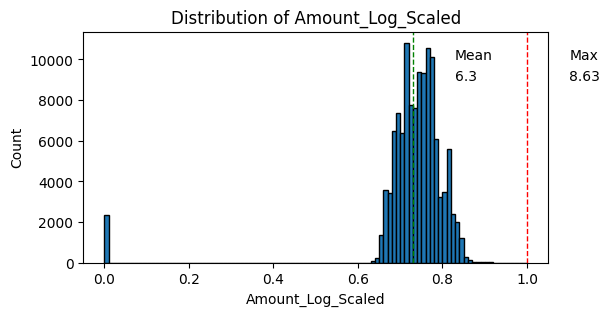

In [33]:
# describe the 'Amount_Log' column
print("Description of 'Amount_Log' column:")
print(df['Amount_Log'].describe())

print(line_break)

print("Description of 'Amount_Log_Scaled' column:")
print(df['Amount_Log_Scaled'].describe())

print(line_break)

# lets visualize the distribution of the 'Amount_Log' column
print("Distribution of 'Amount_Log_Scaled' column:")
plt.figure(figsize=(6, 3))
plt.hist(df['Amount_Log_Scaled'], bins=100, edgecolor='black')
plt.title('Distribution of Amount_Log_Scaled')
plt.xlabel('Amount_Log_Scaled')
plt.ylabel('Count')
plt.axvline(df['Amount_Log_Scaled'].max(), color='red', linestyle='dashed', linewidth=1)
plt.text(df['Amount_Log_Scaled'].max() + 0.1, 10000, 'Max')
plt.text(df['Amount_Log_Scaled'].max() + 0.1, 9000, round(df['Amount_Log'].max(), 2))
plt.axvline(df['Amount_Log_Scaled'].mean(), color='green', linestyle='dashed', linewidth=1)
plt.text(df['Amount_Log_Scaled'].mean() + 0.1, 10000, 'Mean')
plt.text(df['Amount_Log_Scaled'].mean() + 0.1, 9000, round(df['Amount_Log'].mean(), 2))
plt.show()

After doing some research I decided to create 5 bins for the 'Amount' column based on the distribution
*    Bin 1: 0 to 0.708 (covers up to the 25th percentile)
*    Bin 2: 0.708 to 0.742 (covers the 25th to 50th percentile)
*    Bin 3: 0.742 to 0.773 (covers the 50th to 75th percentile)
*    Bin 4: 0.773 to 0.887 (covers the 75th percentile to an arbitrary upper value)
*    Bin 5: 0.887 to 1 (covers the remaining range)

In [35]:
bin_edges = [0, 0.708, 0.742, 0.773, 0.887, 1]

bin_labels = ['Min-Q1', 'Q1-Q2', 'Q2-Q3', 'Q3-Q4', 'Q4-Max']

df['Amount_Log_Scaled_Bins'] = pd.cut(df['Amount_Log_Scaled'], bins=bin_edges, labels=bin_labels, include_lowest=True)

Visualizing the bins

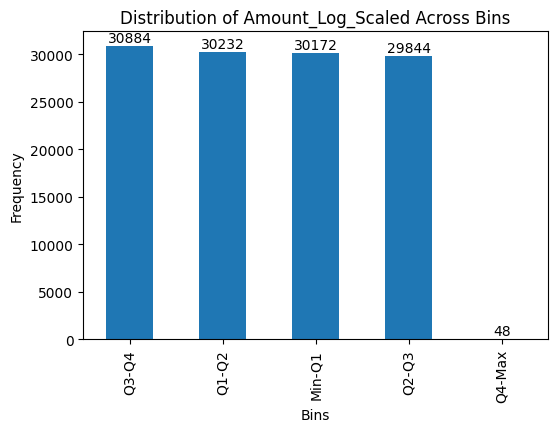

Description of 'Amount_Log_Scaled_Bins' column:
Amount_Log_Scaled_Bins
Q3-Q4     30884
Q1-Q2     30232
Min-Q1    30172
Q2-Q3     29844
Q4-Max       48
Name: count, dtype: int64


In [36]:
# barchart for the 'Amount_Log_Scaled_Bins' column

plt.figure(figsize=(6, 4))
df['Amount_Log_Scaled_Bins'].value_counts().plot(kind='bar')
plt.title('Distribution of Amount_Log_Scaled Across Bins')
for i in range(df['Amount_Log_Scaled_Bins'].value_counts().shape[0]):
    count = df['Amount_Log_Scaled_Bins'].value_counts().values[i]
    str_count = str(count)
    plt.text(i, count + 1600, str_count, ha='center', va='top')
plt.xlabel('Bins')
plt.ylabel('Frequency')
plt.show()

# describe the 'Amount_Log_Scaled_Bins' column
print("Description of 'Amount_Log_Scaled_Bins' column:")
print(df['Amount_Log_Scaled_Bins'].value_counts(dropna=False))

Describing the 'Qty' column we can see that the mean is around 1 with very low standard deviation aswell as the 4th quantile is 1.00 and max is 8, indicates that we have some extreme outliers

In [38]:
# lets find out more about the 'Qty' column
print("Description of 'Qty' column:")
print(df['Qty'].describe())

Description of 'Qty' column:
count    121180.000000
mean          0.961231
std           0.214354
min           0.000000
25%           1.000000
50%           1.000000
75%           1.000000
max           8.000000
Name: Qty, dtype: float64


I looked into the data and realized without surprise that the outliers in 'Amount' are on the same rows as the outliers in 'Qty'

In [39]:
# print the columns 'Qty' and 'Amount' to see rows where Qty is larger than 2
print(df[['Qty', 'Amount']][df['Qty'] > 2].head())

       Qty  Amount
2107     3  1128.0
3289     3  2175.0
11160    5  5495.0
17338    4  1316.0
19180    3  1326.0


Decided to do a log transformation on the 'Qty' column aswell, this time I used the log1p function within the numpy library that handles zero values by adding a + 1 before transformation

In [41]:
# we will perform a log transformation on the 'Qty', log1p is used to handle zero values to avoid errors
df['Qty_Log'] = np.log1p(df['Qty'])

# scaling the 'Qty_Log' column using MinMaxScaler to values between 0 and 1
scaler = MinMaxScaler()
df['Qty_Log_Scaled'] = scaler.fit_transform(df[['Qty_Log']])

I also used the MinMaxScaler to get the values between 0 and 1 in the new Qty_Log_Scaled column

In [42]:
print("Description of 'Qty_Log_Scaled' column:")
print(df['Qty_Log_Scaled'].value_counts())

Description of 'Qty_Log_Scaled' column:
Qty_Log_Scaled
0.315465    115665
0.000000      5136
0.500000       337
0.630930        31
0.732487         8
0.815465         2
1.000000         1
Name: count, dtype: int64


Evaluating the columns to see which ones we should do one-hot encoding on

In [43]:
# get a list of the columns and how many unique values they have
print("Unique values in each column:")
print(df.nunique())

Unique values in each column:
index                     121180
Order ID                  113030
Date                          91
Status                        12
Fulfilment                     2
Sales Channel                  1
ship-service-level             2
Style                       1373
SKU                         7157
Category                       9
Size                          11
ASIN                        7153
Courier Status                 3
Qty                            7
currency                       1
Amount                      1410
ship-city                   8704
ship-state                    68
ship-postal-code            9273
ship-country                   1
promotion-ids               5787
B2B                            2
fulfilled-by                   1
Unnamed: 22                    1
Weekday                        7
Is_weekday                     2
Amount_Log                  1410
Amount_Log_Scaled           1410
Amount_Log_Scaled_Bins         5
Qty_Log      

Since I don't really know which algorithm will be used or how the model will be trained on the data I decided to just encode one column to test it out

In [44]:
# one-hot encode the 'Fulfilment' column into 'Fulfilment_Amazon' and 'Fulfilment_Merchant'
df = pd.get_dummies(df, columns=['Fulfilment'], prefix=['Fulfilment'])
# and convert the new columns to int
df['Fulfilment_Merchant'] = df['Fulfilment_Merchant'].astype(int)
df['Fulfilment_Amazon'] = df['Fulfilment_Amazon'].astype(int)

There seems to be a a lot of factors to consider when choosing which categorical columns to perform OneHot Encoding on

#### Printing the finished dataframe

In [46]:
df.head()

,index,Order ID,Date,Status,Sales Channel,ship-service-level,Style,SKU,Category,Size,ASIN,Courier Status,Qty,currency,Amount,ship-city,ship-state,ship-postal-code,ship-country,promotion-ids,B2B,fulfilled-by,Unnamed: 22,Weekday,Is_weekday,Amount_Log,Amount_Log_Scaled,Amount_Log_Scaled_Bins,Qty_Log,Qty_Log_Scaled,Fulfilment_Amazon,Fulfilment_Merchant
0,0,405-8078784-5731545,2022-04-30,Cancelled,Amazon.in,Standard,SET389,SET389-KR-NP-S,set,S,B09KXVBD7Z,Unknown,0,INR,647.62,MUMBAI,MAHARASHTRA,400081.0,IN,NaN,0,Easy Ship,NaN,Saturday,0,6.474847,0.750460,Q2-Q3,0.000000,0.000000,0,1
1,1,171-9198151-1101146,2022-04-30,Shipped - Delivered to Buyer,Amazon.in,Standard,JNE3781,JNE3781-KR-XXXL,kurta,3XL,B09K3WFS32,Shipped,1,INR,406.00,BENGALURU,KARNATAKA,560085.0,IN,Amazon PLCC Free-Financing Universal Merchant ...,0,Easy Ship,NaN,Saturday,0,6.008813,0.696445,Min-Q1,0.693147,0.315465,0,1
2,2,404-0687676-7273146,2022-04-30,Shipped,Amazon.in,Expedited,JNE3371,JNE3371-KR-XL,kurta,XL,B07WV4JV4D,Shipped,1,INR,329.00,NAVI MUMBAI,MAHARASHTRA,410210.0,IN,IN Core Free Shipping 2015/04/08 23-48-5-108,1,NaN,NaN,Saturday,0,5.799093,0.672137,Min-Q1,0.693147,0.315465,1,0
3,3,403-9615377-8133951,2022-04-30,Cancelled,Amazon.in,Standard,J0341,J0341-DR-L,western dress,L,B099NRCT7B,Unknown,0,INR,753.33,PUDUCHERRY,PUDUCHERRY,605008.0,IN,NaN,0,Easy Ship,NaN,Saturday,0,6.625830,0.767959,Q2-Q3,0.000000,0.000000,0,1
4,4,407-1069790-7240320,2022-04-30,Shipped,Amazon.in,Expedited,JNE3671,JNE3671-TU-XXXL,top,3XL,B098714BZP,Shipped,1,INR,574.00,CHENNAI,TAMIL NADU,600073.0,IN,NaN,0,NaN,NaN,Saturday,0,6.354370,0.736496,Q1-Q2,0.693147,0.315465,1,0


### Save the dataframe to xlsx to view the finished dataset

In [48]:
# save an xlsx file of the cleaned dataset
#df.to_excel('AmazonDataSales_cleaned.xlsx', index=False)